In [13]:
%%script bash --bg --out stdout
litex_server uart /dev/ttyUSB0 115200

Starting job # 2 in a separate thread.


In [18]:
print(stdout.readlines())

[]


In [1]:
from litex.soc.tools.remote import RemoteClient
from struct import pack, unpack
import time

In [4]:
for i in range(32):
    try:
        r = RemoteClient(csr_csv="build/csr.csv", debug=False, port=1234 + i)
        r.open()
        print("Connected to Port", 1234 + i)
        break
    except ConnectionRefusedError:
        pass

Connected to Port 1235


In [5]:
print(hex(r.regs.ctrl_scratch.read()))
r.regs.ctrl_scratch.write(0xDEADBEEF)
print(hex(r.regs.ctrl_scratch.read()))

0x12345678
0xdeadbeef


In [6]:
def getId():
    s = ""
    for i in range(64):
        temp = r.read(r.bases.identifier_mem + i * 4)
        if temp == 0:
            break
        s += chr(temp & 0xFF)
    return s
getId()

'Wir trampeln durchs Getreide ... 2019-03-22 19:48:44'

# SPI


    config signal:
        1 offline: all pins high-z (reset=1)
        1 active: cs/transfer active (read-only)
        1 pending: transfer pending in intermediate buffer (read-only)
        1 cs_polarity: active level of chip select (reset=0)
        1 clk_polarity: idle level of clk (reset=0)
        1 clk_phase: first edge after cs assertion to sample data on (reset=0)
            (clk_polarity, clk_phase) == (CPOL, CPHA) in Freescale language.
            (0, 0): idle low, output on falling, input on rising
            (0, 1): idle low, output on rising, input on falling
            (1, 0): idle high, output on rising, input on falling
            (1, 1): idle high, output on falling, input on rising
            There is never a clk edge during a cs edge.
        1 lsb_first: LSB is the first bit on the wire (reset=0)
        1 half_duplex: 3-wire SPI, in/out on mosi (reset=0)
        8 undefined
        8 div_write: counter load value to divide this module's clock
            to generate the SPI write clk (reset=0)
            f_clk/f_spi_write == div_write + 2
        8 div_read: ditto for the read clock

    xfer_config signal:
        16 cs: active high bit mask of chip selects to assert (reset=0)
        6 write_len: 0-M bits (reset=0)
        2 undefined
        6 read_len: 0-M bits (reset=0)
        2 undefined

In [7]:
r.regs.spi_config.write(0xFFFF0000)
# 16 bit write transfer (includes read as is 4 wire)
r.regs.spi_xfer.write(0x0010FFFF)

In [27]:
rw = 1
adr = 0x02
data = 0x80
word = (rw<<15) | (adr<<8) | (data & 0xFF)
word <<= 16
print(hex(word))

r.regs.spi_mosi_data.write(word)
r.regs.spi_start.write(1)

print(hex(r.regs.spi_miso_data.read()))

0x82800000
0x82800001


In [8]:
def set_ltc_reg(adr, val):
    word = (0 << 15) | ((adr & 0x7F) << 8) | (val & 0xFF)
    word <<= 16
    r.regs.spi_mosi_data.write(word)
    r.regs.spi_start.write(1)

def get_ltc_reg(adr):
    word = (1 << 15) | ((adr & 0x7F) << 8)
    word <<= 16
    r.regs.spi_mosi_data.write(word)
    r.regs.spi_start.write(1)
    return r.regs.spi_miso_data.read() & 0xFF

In [9]:
for i in range(5):
    print("{:2x}: {:02x}".format(i, get_ltc_reg(i)))

 0: 00
 1: 00
 2: 00
 3: 00
 4: 00


In [10]:
set_ltc_reg(0, 0x80)   # Software reset

In [11]:
set_ltc_reg(1, 0x10)   # Sleep mode

In [12]:
set_ltc_reg(1, 0x00)   # Waky waky

In [36]:
tpValue = 0x3456
set_ltc_reg(3, (1<<7) | tpValue >> 8)   # Test pattern on + value MSB
set_ltc_reg(4, tpValue & 0xFF)          # Test pattern value LSB

In [161]:
hex((get_ltc_reg(3) & 0x3F) << 8 | get_ltc_reg(4))

'0x0'

# FRM clock frequency

In [14]:
tempLog = []
while True:
    time.sleep(0.5)
    tempLog.append(r.regs.f_frame_value.read())
    print("\r{:9d}".format(tempLog[-1]), end="")

124999994

KeyboardInterrupt: 

In [15]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


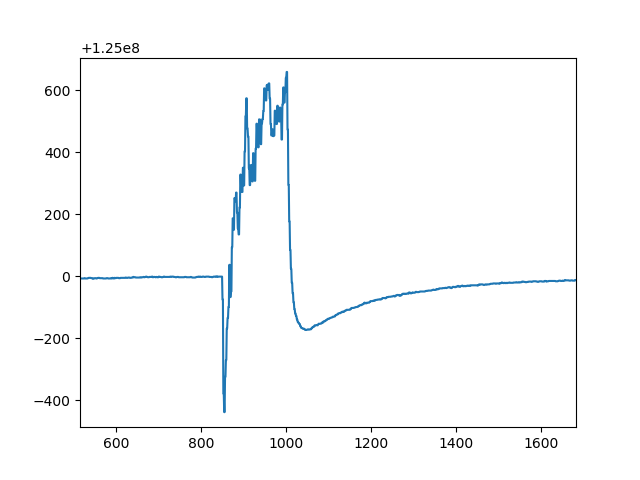

In [16]:
plot(tempLog)

In [50]:
r.close()